<a href="https://colab.research.google.com/github/VishalV177/Image-caption-generator-v3/blob/main/FINAL_YEAR_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers.merge import add
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.pyplot as plt

In [ ]:
def load_description(text):
	mapping = dict()
	for line in text.split("\n"):
		token = line.split("\t")
		if len(line) < 2: # remove short descriptions
			continue
		img_id = token[0].split('.')[0] # name of the image
		img_des = token[1]			 # description of the image
		if img_id not in mapping:
			mapping[img_id] = list()
		mapping[img_id].append(img_des)
	return mapping

token_path = 'Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()
descriptions = load_description(text)
print(descriptions['1000268201_693b08cb0e'])


['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [ ]:
import string
def clean_description(desc):
	for key, des_list in desc.items():
		for i in range(len(des_list)):
			caption = des_list[i]
			caption = [ch for ch in caption if ch not in string.punctuation]
			caption = ''.join(caption)
			caption = caption.split(' ')
			caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
			caption = ' '.join(caption)
			des_list[i] = caption

clean_description(descriptions)
descriptions['1000268201_693b08cb0e']


['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
def to_vocab(desc):
	words = set()
	for key in desc.keys():
		for line in desc[key]:
			words.update(line.split())
	return words
vocab = to_vocab(descriptions)


In [ ]:
import glob
images = 'Images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

train_path = 'Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n")
train_img = [] # list of all images in training set
for im in img:
	if(im[len(images):] in train_images):
		train_img.append(im)
		
# load descriptions of training set in a dictionary. Name of the image will act as ey
def load_clean_descriptions(des, dataset):
	dataset_des = dict()
	for key, des_list in des.items():
		if key+'.jpg' in dataset:
			if key not in dataset_des:
				dataset_des[key] = list()
			for line in des_list:
				desc = 'startseq ' + line + ' endseq'
				dataset_des[key].append(desc)
	return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_images)
print(train_descriptions['1000268201_693b08cb0e'])


['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
def preprocess_img(img_path):
	# inception v3 excepts img in 299 * 299 * 3
	img = load_img(img_path, target_size = (299, 299))
	x = img_to_array(img)
	# Add one more dimension
	x = np.expand_dims(x, axis = 0)
	x = preprocess_input(x)
	return x

def encode(image):
	image = preprocess_img(image)
	vec = model.predict(image)
	vec = np.reshape(vec, (vec.shape[1]))
	return vec

base_model = InceptionV3(weights = 'imagenet')
model = Model(base_model.input, base_model.layers[-2].output)
from pickle import load
def load_doc(filename):
    file = open(filename , 'r')
    text = file.read()
    file.close()
    return text
def load_photo_features(filename):
    all_features = load(open(filename,'rb'))
    features = {k : all_features[k] for k in all_features}
    return features



In [ ]:
train_features=load_photo_features("train_features.pkl")

In [ ]:
# list of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
	for caption in val:
		all_train_captions.append(caption)

# consider only words which occur atleast 10 times
vocabulary = vocab
threshold = 10 # you can change this value according to your need
word_counts = {}
for cap in all_train_captions:
	for word in cap.split(' '):
		word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]

# word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
	wordtoix[word] = ix
	ixtoword[ix] = word
	ix += 1
vocab_size = len(ixtoword) + 1
# find the maximum length of a description in a dataset
max_length = max(len(des.split()) for des in all_train_captions)
max_length


34

In [ ]:
print(vocab_size)
print(max_length)

1652
34


In [ ]:
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
	pic = train_features[key + '.jpg']
	for cap in des_list:
		seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
		for i in range(1, len(seq)):
			in_seq, out_seq = seq[:i], seq[i]
			in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
			out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
			# store
			X1.append(pic)
			X2.append(in_seq)
			y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)

# load glove vectors for embedding layer
embeddings_index = {}
golve_path ='glove/glove.6B.200d.txt'
glove = open(golve_path, 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
	values = line.split(" ")
	word = values[0]
	indices = np.asarray(values[1: ], dtype = 'float32')
	embeddings_index[word] = indices

emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
	emb_vec = embeddings_index.get(word)
	if emb_vec is not None:
		emb_matrix[i] = emb_vec
emb_matrix.shape

(1652, 200)

In [ ]:
ip1 = Input(shape = (2048, ))
fe1 = Dropout(0.50)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.50)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model.fit([X1, X2], y, epochs = 40, batch_size = 256)
# you can increase the number of epochs for better results

In [ ]:
from keras.models import model_from_json
model_json=model.to_json()
with open("model40.json","w") as json_file:
    json_file.write(model_json)
model.save_weights("model40.h5")
print("saved model to desk")

In [ ]:
from keras.models import model_from_json
json_file=open("model40.json","r")
loaded_model_json=json_file.read()
json_file.close()
loaded_model=model_from_json(loaded_model_json)
loaded_model.load_weights("model40.h5")

In [ ]:
def greedy_search(pic):
	start = 'startseq'
	#pic = pic(shape = (2048, ))
	for i in range(max_length):
		seq = [wordtoix[word] for word in start.split() if word in wordtoix]
		seq = pad_sequences([seq], maxlen = max_length)
		yhat = loaded_model.predict([pic, seq])
		yhat = np.argmax(yhat)
		word = ixtoword[yhat]
		start += ' ' + word
		if word == 'endseq':
			break
	final = start.split()
	final = final[1:-1]
	final = ' '.join(final)
	return final

In [ ]:
from keras.preprocessing import sequence
def beam_search_predictions(image, beam_index):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = loaded_model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

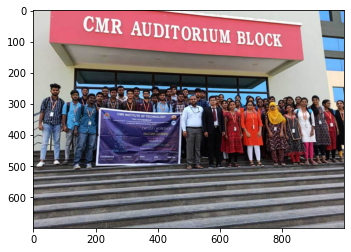

Greedy Search: group of people are standing around in front of building


In [ ]:
pic="cmrit1.jpg"
img = load_img(pic, target_size = (299, 299))
x = img_to_array(img)
# Add one more dimension
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
base_model = InceptionV3(weights = 'imagenet')
model1 = Model(base_model.input, base_model.layers[-2].output)
vec = model1.predict(x)
vec = np.reshape(vec, (vec.shape[1]))
image = vec.reshape((1,2048))

x=plt.imread(pic)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedy_search(image))


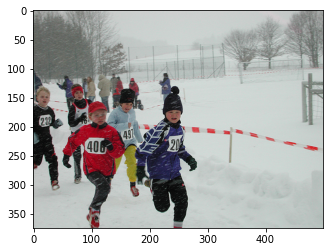

Greedy Search: group of people racing on snowy hill


In [ ]:
pic = '72218201_e0e9c7d65b.jpg'
image = train_features[pic].reshape((1,2048))

x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedy_search(image))

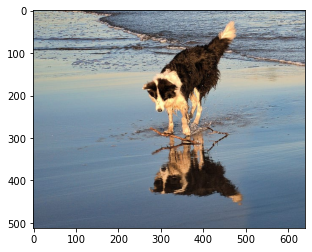

Greedy Search: dog running through the water


In [ ]:
pic="example.jpg"
img = load_img(pic, target_size = (299, 299))
x = img_to_array(img)
# Add one more dimension
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
base_model = InceptionV3(weights = 'imagenet')
model1 = Model(base_model.input, base_model.layers[-2].output)
vec = model1.predict(x)
vec = np.reshape(vec, (vec.shape[1]))
image = vec.reshape((1,2048))

x=plt.imread(pic)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedy_search(image))


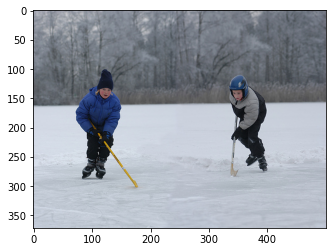

Greedy Search: two children are playing hockey in the snow


In [ ]:
pic = '86542183_5e312ae4d4.jpg'
image = train_features[pic].reshape((1,2048))

x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedy_search(image))

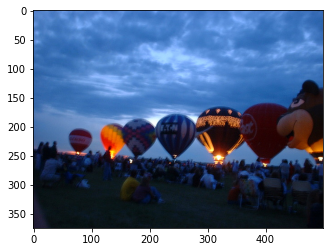

Greedy Search: crowd of people watch as hot air balloon
Beam Search, K = 3: crowd of people watch as hot air balloon
Beam Search, K = 5: crowd of people watch as hot air balloon into the air at night
Beam Search, K = 7: crowd of people watch as hot air balloon at night
Beam Search, K = 10: group of hot air balloons at night


In [ ]:
pic = '107318069_e9f2ef32de.jpg'
image = train_features[pic].reshape((1,2048))

x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedy_search(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

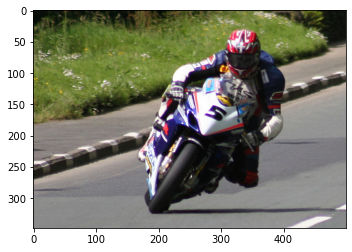

Greedy Search: man on motorcycle touches his knee


In [ ]:
pic = '161669933_3e7d8c7e2c.jpg'
image = train_features[pic].reshape((1,2048))

x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedy_search(image))

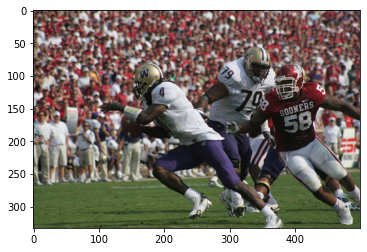

Greedy Search: football player in red and white uniform is being tackled by oklahoma player


In [ ]:
pic = '241346260_f50d57b517.jpg'
image = train_features[pic].reshape((1,2048))

x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedy_search(image))

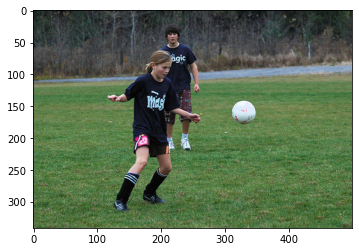

Greedy Search: two boys playing soccer


In [ ]:
pic = '278608022_4175813019.jpg'
image = train_features[pic].reshape((1,2048))

x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedy_search(image))

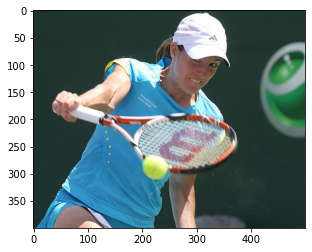

Greedy Search: woman playing tennis


In [ ]:
pic = '2393924525_1bf45ca217.jpg'
image = train_features[pic].reshape((1,2048))

x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy Search:",greedy_search(image))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def generate_desc(model , tokenizer , photo , max_length):
    
    input_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence] , maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence],verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        
        # get word from id
        word = word_for_id(next_word_id , tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text
def evaluate_model(model , desciptions , photos , tokenizer , max_length):
    actual , predicted = list() , list()
    
    for key , desc_list in desciptions.items():
        
        key=key+".jpg"
        image = photos[key].reshape((1,2048))
        generated_desc=greedy_search(image)
        references = [d.split() for d in desc_list]
        generated_desc='startseq'+" "+generated_desc+" "+'endseq'
        actual.append(references)
        predicted.append(generated_desc.split())
    
    print('Bleu_Score -1 = %f'%corpus_bleu(actual , predicted , weights=(1,0,0,0)))
    

In [ ]:
test_path = 'Flickr_8k.testImages.txt'
test_images = open(test_path, 'r', encoding = 'utf-8').read().split("\n")
test=set(test_images)

In [ ]:
train_path = 'Flickr_8k.trainImages.txt'
tain_images = open(test_path, 'r', encoding = 'utf-8').read().split("\n")
train=set(train_images)
train.remove('')
test_descriptions = load_clean_descriptions(descriptions,test)
train_descriptions=load_clean_descriptions(descriptions,train)

In [ ]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
        
    return all_desc
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [ ]:
tokenizer = create_tokenizer(train_descriptions)

In [ ]:
def load_clean_features(features, dataset):
	dataset_feature = dict()
	for key, feature in features.items():
		if key in dataset:
			dataset_feature[key]=(feature)
	return dataset_feature

In [ ]:
test_descriptions = load_clean_descriptions(descriptions,test)

In [ ]:
import glob
images = 'Images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
test_path = 'Flickr_8k.testImages.txt'
test_images = open(test_path, 'r', encoding = 'utf-8').read().split("\n")
test_img = [] # list of all images in training set
for im in img:
	if(im[len(images):] in test_images):
		test_img.append(im)
test_features=load_clean_features(train_features,test_images)

In [ ]:
evaluate_model(model , test_descriptions , test_features , tokenizer , max_length)

Bleu_Score -1 = 0.649467


In [ ]:
def evaluate_modele1(model , desciptions , photos , tokenizer , max_length):
    actual , predicted = list() , list()
    
    for key , desc_list in desciptions.items():
        
        key=key+".jpg"
        image = photos[key].reshape((1,2048))
        generated_desc=greedy_search(image)
        references = [d.split() for d in desc_list]
        generated_desc='startseq'+" "+generated_desc+" "+'endseq'
        actual.append(references)
        predicted.append(generated_desc.split())
    
    print('Bleu_Score -1 = %f'%corpus_bleu(actual , predicted , weights=(1,0,0,0)))
    print('Bleu_Score -2 = %f'%corpus_bleu(actual , predicted , weights=(0.5,0.5,0,0)))
    
    print('Bleu_Score -3 = %f'%corpus_bleu(actual , predicted , weights=(0.33,0.33,0.33,0))) 
    
    print('Bleu_Score -4 = %f'%corpus_bleu(actual , predicted , weights=(0.25,0.25,0.25,0.25)))

In [ ]:
evaluate_modele1(model , test_descriptions , test_features , tokenizer , max_length)

Bleu_Score -1 = 0.649467
Bleu_Score -2 = 0.446046
Bleu_Score -3 = 0.318250
Bleu_Score -4 = 0.219204
